In [126]:
import pickle
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import imageio

In [127]:
def load_data_from_pkl(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data

In [128]:
import numpy as np

left_features_dict = load_data_from_pkl('feat/resnet50/resnet50_train_left_features.pkl')
right_features_dict = load_data_from_pkl('feat/resnet50/resnet50_train_right_features.pkl')
triplets = load_data_from_pkl('train_formated_data.pkl')

# 计算匹配对之间的L2距离
distances = []
for left, right, label in triplets:
    if label == 1:  # 只考虑匹配的对
        distance = np.linalg.norm(left_features_dict[left] - right_features_dict[right])
        distances.append(distance)

# 计算平均L2距离
avg_distance = np.mean(distances)
print("Average L2 distance for matching pairs:", avg_distance)

# 使用平均距离为margin选择一个合适的值。您可以选择avg_distance，也可以选择稍大或稍小的值。
margin = avg_distance  # 这是一个初始选择，您可能需要根据实验结果进行调整
print("Suggested margin:", margin)


Average L2 distance for matching pairs: 35.068905
Suggested margin: 35.068905


In [129]:
# 加载数据
val_triplets = load_data_from_pkl('val_simple_dict.pkl')
# left_features_val = np.array([left_features_dict[triplet[0]] for triplet in val_triplets])
# right_features_val = np.array([right_features_dict[triplet[1]] for triplet in val_triplets])
# labels_val = np.array([triplet[2] for triplet in val_triplets])

In [132]:
# 加载数据
left_features_dict = load_data_from_pkl('feat/resnet50/resnet50_train_left_features.pkl')
right_features_dict = load_data_from_pkl('feat/resnet50/resnet50_train_right_features.pkl')
triplets = load_data_from_pkl('train_formated_data.pkl')

# 初始化列表来保存特征向量和标签
left_features = []
right_features = []
labels = []

for triplet in triplets:
    left_name, right_name, label = triplet
    
    # 从字典中获取特征向量
    left_feature = left_features_dict[left_name]
    right_feature = right_features_dict[right_name]
    
    # 添加到列表
    left_features.append(left_feature)
    right_features.append(right_feature)
    labels.append(label)

# 将列表转换为numpy数组
left_features = np.array(left_features)
right_features = np.array(right_features)
labels = np.array(labels, dtype=np.float32)


print('left_features.shape: ', left_features.shape)
print('right_features.shape: ', right_features.shape)
print('labels.shape: ', labels.shape)

left_features.shape:  (3200, 2048)
right_features.shape:  (3200, 2048)
labels.shape:  (3200,)


In [133]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Subtract, Flatten, Dropout
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense
from keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_base_network(input_shape):
    '''Enhanced Siamese Network'''
    input = Input(shape=input_shape)
    x = Dense(2048, activation='relu')(input)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    
    return Model(input, x)

input_dim = (2048,)
base_network = create_base_network(input_dim)

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

siamese_net = Model([input_a, input_b], distance)
siamese_net.compile(optimizer=Adam(learning_rate=0.0001), loss=contrastive_loss)


In [134]:
history = siamese_net.fit([left_features, right_features], labels, 
                          epochs=30, batch_size=16)


Epoch 1/30
200/200 [==============================] - 3s 10ms/step - loss: 245.5444
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 167.1951
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 126.9363
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 107.4805
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 94.5079
Epoch 6/30
200/200 [==============================] - 2s 10ms/step - loss: 83.6468
Epoch 7/30
200/200 [==============================] - 2s 11ms/step - loss: 76.3123
Epoch 8/30
200/200 [==============================] - 2s 10ms/step - loss: 69.0729
Epoch 9/30
200/200 [==============================] - 2s 10ms/step - loss: 64.3262
Epoch 10/30
200/200 [==============================] - 2s 10ms/step - loss: 61.0187
Epoch 11/30
200/200 [==============================] - 2s 10ms/step - loss: 53.8511
Epoch 12/30
200/200 [==============================] - 2s 10ms/step - loss: 54.68

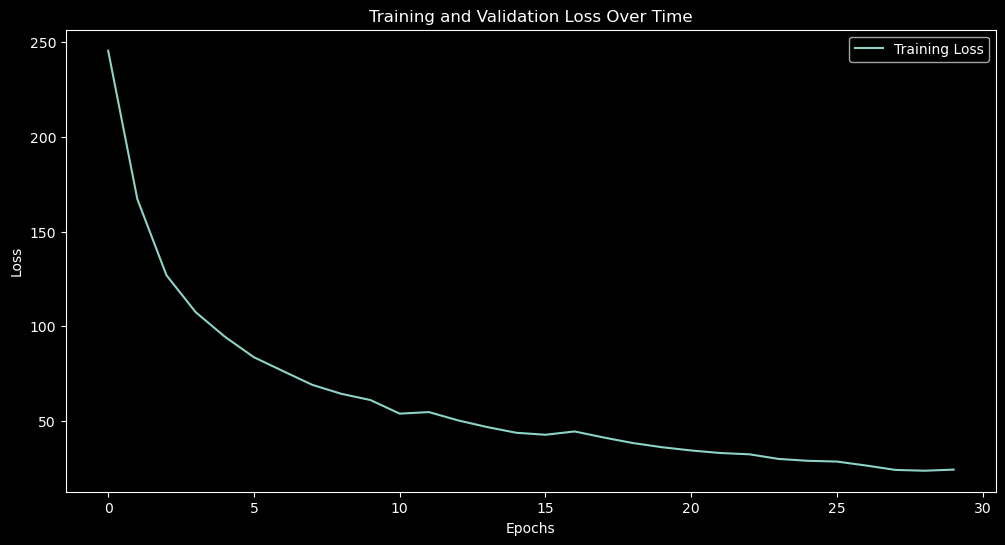

In [135]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


In [136]:
def select_best_match_for_left(val_triplets, left_features_dict, right_features_dict, model):
    best_matches = {}
    
    for left_id, right_candidates_ids in val_triplets.items():
        # 获取左侧特征
        left_feature = left_features_dict[left_id]
        
        # 获取所有右侧候选特征
        right_candidates_features = np.array([right_features_dict[id] for id in right_candidates_ids])
        
        # 将左侧特征复制为与右侧候选相同的形状以进行批量计算
        left_batch = np.tile(left_feature, (len(right_candidates_features), 1))
        
        # 使用模型计算距离
        distances = model.predict([left_batch, right_candidates_features])
        
        # 选择距离最小的右侧图像的索引
        best_match_index = np.argmin(distances)
        best_matches[left_id] = right_candidates_ids[best_match_index]

    return best_matches


In [137]:
index = select_best_match_for_left(val_triplets, left_features_dict, right_features_dict, siamese_net)

1/1 [==============================] - 0s 12ms/step


In [138]:
correct = sum(1 for key, value in index.items() if val_triplets[key][0] == value)
accuracy = correct / len(index)

print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 13.25%
